In [1]:
root = dirname(pwd())
src = joinpath(root, "src")
include(joinpath(root, "src", "stfunc", "utils.jl"))
include(joinpath(root, "src", "stfunc", "hdf5_utils.jl"))
include(joinpath(root, "src", "stfunc", "data_energy.jl"))

EnergyData (generic function with 1 method)

In [17]:
import PyPlot as pl
pl.pygui(false)
pl.pygui(:qt5)

:qt5

In [18]:
root = dirname(@__DIR__)
get_fig_dir(data_source) = joinpath(root, @sprintf("data_%s", data_source), "output", "fig")

get_fig_dir (generic function with 1 method)

# Simple model to estimate required electrical storage capacity

## Input data are Load $L$ and sum of wind onshore, wind offshore and solar $E$
1. Determine trend over time by approximating time series data by a second order polynomial
    * $D_{trend}(t) = a + b t + c t^2$
2. Detrend data 
    * $D_{de}(t) = D(t) \dfrac{D_{trend}(t_h)}{D_{trend}(t)}$
3. Scale E data
    * $E_{de,sc} = E_{de} \dfrac{<L>}{<E>}$

In [19]:
"""
    scale_and_detrend(Load, EE)

    EE is scaled such that mean(EE) == mean(Load)
"""
function scale_and_detrend(Load, EE)
    n = length(Load)
    nh = div(n,2)

    # determine trend by fittind data with a k'th order polynomial
    k = 2
    Load_trend = polynomial_fit(Load, k)
    tL = @. Load_trend / Load_trend[nh]
    Load_de = @. Load / tL

    scale = (mean(Load) / mean(EE))
    EE_sc = @. EE * scale
    EE_trend = polynomial_fit(EE_sc, k)
    tE = @. EE_trend / EE_trend[nh]
    EE_de = @. EE_sc / tE
    EE_de_sc = EE_de * mean(Load_de)/mean(EE_de)

    # diff between detrended EE and Load
    ΔEL = (EE_de_sc - Load_de)

    EE_de_sc, EE_trend, ΔEL, Load_de, Load_trend
end

scale_and_detrend

## Compute storage level

$S(t) = S(t-1) + \alpha \Delta S(t)$

$\Delta S(t) = (f \; E_{de,sc} - L_{de})\Delta t$

if  $S(t-1) + \Delta S(t) < C \rightarrow \alpha = 1$ else $\alpha = 0$

* $S(t)$ - storage filllevel
* $C$ - storage capacity
* $f$ - over production factor
    * $\dfrac{f \; E_{de,sc} - L_{de}}{L_{de}} \; 100$
    


In [20]:
"""
    compute_storage_levele(dates, Load_de, EE_scaled_de, over_production, SC)

    dates :
    Load_de :
    EE_scaled_de :
    over_production : over production capacity factor, 1.0 is no over production capacity
    SC : storage capacity
"""
function compute_storage_level(dates, Load, EE, eunit, over_production, SC)
    M2 = uconvert(eunit, "TW")
    Load = @. Load * M2
    EE = @. EE * M2

    ms = Dates.value(dates[2] - dates[1])
    Δh = ms/(3.6e6)

    EE = EE .* over_production
    ΔS = (EE - Load) .* Δh

    n  = size(EE, 1)
    dS = zeros(Float64, n)
    store = ones(Float64, n)

    dS[1] = ΔS[1]
    store[1] = dS[1]
    for i in 2:n
        dS[i] = ΔS[i]
        if store[i-1] + dS[i] > SC && dS[i] > 0.0
            dS[i] = max(0.0, (SC - (store[i-1] + dS[i])))
        end
        store[i] = store[i-1] + dS[i]
    end
    store
end

compute_storage_level

### Estimating $C$ as a function of $f$

In [21]:
"""
    determine_overproduction(Load, EE_scaled_de)

    determine minimum storage capacity as a function of over producntion

    Load :
    EE_scaled_de :
"""
function determine_overproduction(Load, EE, eunit)
    overprod = collect(LinRange(1.05, 1.5, 20))
    sc = []
    for op in overprod
        SC = 1.0
        minS = -1.0
        it = 0
        while minS < 0.0 && it < 50
            store = compute_storage_level(dates, Load, EE, eunit, op, SC)
            minS = minimum(store)
            SC = SC - minS
            it += 1
        end
        push!(sc, SC)
    end
    plt.plot(overprod, sc, "r.")
end

determine_overproduction

In [22]:
function plot_EL(dates, Load, EE, averaging_hours, fig_dir, eunit)
    pl.figure()
    pl.plot(dates, Load, label="Load")
    pl.plot(dates, EE, label="EE")
    pl.xlabel("time")
    pl.ylabel(@sprintf("P [%s]", eunit))
    pl.grid()
    pl.legend()
    if averaging_hours > 1
        pl.title(@sprintf("averaged, %d hours window", averaging_hours))
        pl.savefig(joinpath(fig_dir, @sprintf("EE_averaged.png")))
    else
        pl.savefig(joinpath(fig_dir, @sprintf("EE.png")))
    end
end

plot_EL (generic function with 1 method)

In [23]:
function plot_detrended(dates::Vector{DateTime}, EE::Vector{Float64}, EE_de::Vector{Float64}, EE_trend::Vector{Float64}, ΔEL::Vector{Float64},
                        Load::Vector{Float64}, Load_de::Vector{Float64}, Load_trend::Vector{Float64}, fig_dir::String, eunit::String; av = true)
    eunit_factor = uconvert(eunit, "GW")

    label1 = "Load"
    label2 = "Load_de"
    path1  = "Load_detrended.png"
    path2  = "Load_diff_detrended.png"
    if av == true
        label1 = "Load_av"
        label2 = "Load_av_de"
        path1  = "Load_av_detrended.png"
    end

    pl.figure()
    pl.plot(dates, Load        .* eunit_factor, label = label1)
    pl.plot(dates, Load_de     .* eunit_factor, label = label2)
    pl.plot(dates, Load_trend  .* eunit_factor, "r", linewidth=3, label = "Load_trend")
    pl.xlabel("time")
    pl.ylabel("P [GW]")
    pl.grid()
    pl.legend()
    pl.title("Load detrended")
    pl.savefig(joinpath(fig_dir, path1))

    label1 = "EE"
    label2 = "EE_de"
    label3 = "EE_de - Load"
    path1  = "EE_detrended.png"
    path2  = "EE_diff_detrended.png"
    if av == true
        label1 = "EE_av"
        label2 = "EE_av_de"
        label3 = "EE_av_de - Load_av"
        path1  = "EE_av_detrended.png"
        path2  = "EE_av_diff_detrended.png"
    end

    pl.figure()
    pl.plot(dates, EE       .* eunit_factor, label = label1)
    pl.plot(dates, EE_de    .* eunit_factor, label = label2)
    pl.plot(dates, EE_trend .* eunit_factor,  "r", linewidth=3, label = "EE_trend")
    pl.xlabel("time")
    pl.ylabel("P [GW]")
    pl.grid()
    pl.legend()
    pl.title("EE detrended")
    if isdir(figdir) pl.savefig(joinpath(fig_dir, path1)) end

    pl.figure()
    pl.plot(dates, ΔEL .* eunit_factor, label = label3)
    pl.xlabel("time")
    pl.ylabel("(P_E - P_L) [GW]")
    pl.legend()
    pl.grid()
    pl.title("diff detrended")
    if isdir(figdir) pl.savefig(joinpath(fig_dir, path2)) end
end

plot_detrended (generic function with 1 method)

In [24]:
function compute_storage_fill_and_plot(dates, Load, EE, fig_dir, eunit, pngpath)
    SC = [13.0, 25.0, 34.0, 44.0]
    op = [1.5, 1.2, 1.15, 1.1, 1.05]
    prozent = "%"
    pl.figure()
    for (s,o) in zip(SC, op)
        store = compute_storage_level(dates, Load, EE, eunit, o, s)
        label = @sprintf("SC=%2.f, op = %3.f %s, min = %3.f", s, (o-1.0)*100.0, prozent, minimum(store))
        pl.plot(dates, store, label = label)
    end
    pl.xlabel("time")
    pl.ylabel("storage fill [TWh]")
    pl.legend()
    pl.grid()
    if isdir(figdir)  pl.savefig(joinpath(fig_dir, pngpath.*".png")) end
end

compute_storage_fill_and_plot (generic function with 1 method)

## Load data

In [25]:
data_source = ["ise", "opds"][1]
eunit = ["MW", "GW", "TW"][2]
fig_dir = get_fig_dir(data_source)
data = EnergyData(data_source, eunit);

## E = Wind offshoe + Wind onshore + Solar

In [26]:
Load = data.Load
EE = @. data.Woff + data.Won + data.Solar;
dates = data.dates;

### plot $E$ and $L$ data vs time

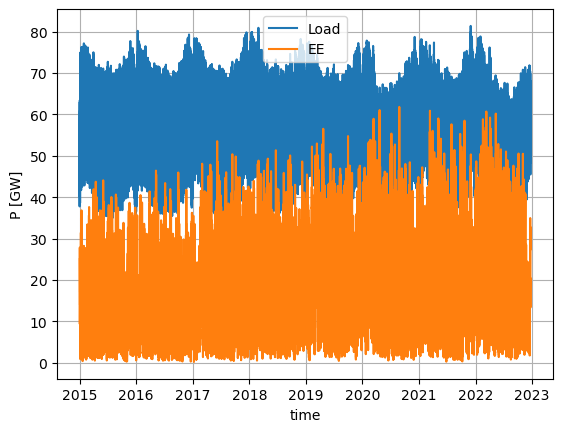

In [27]:
plot_EL(dates, Load, EE, 0, fig_dir, eunit)

### scale and detrend

In [28]:
EE_de, EE_trend, ΔEL, Load_de, Load_trend = scale_and_detrend(Load, EE);

### plot detrended data

In [29]:
plot_detrended(dates, EE, EE_de, EE_trend, ΔEL, Load, Load_de, Load_trend, fig_dir, eunit, av = false)

LoadError: UndefVarError: figdir not defined

### compute storage fill and plot

In [30]:
compute_storage_fill_and_plot(dates, Load_de, EE_de, fig_dir, eunit, "storage");

LoadError: UndefVarError: figdir not defined

In [31]:
function ee_bio_nuclear()
    data_source = ["ise", "opds"][1]
    eunit = ["MW", "GW", "TW"][2]
    fig_dir = get_fig_dir(data_source)
    data = EnergyData(data_source, eunit);
    dates = data.dates

    Load = data.Load
    EE = @. data.Woff + data.Won + data.Solar;


    uts = date2uts(DateTime(2022,1,1))
    index = findfirst(==(uts), data.uts)

    pl.figure()
    pl.plot(dates, EE, label = "EE")
    pl.plot(dates, data.Bio, label="Bio")
    pl.plot(dates, data.Nuclear, label = "Nuclear")
    pl.title("data source: https://api.energy-charts.info/")
    pl.xlabel("time")
    pl.ylabel("P [GW]")
    pl.grid()
    pl.legend()
    if isdir(fig_dir)  pl.savefig(joinpath(fig_dir, "electric_power_production__bio_nuclear.png")) end

    pl.figure()
    pl.plot(dates[index:end], EE[index:end], label = "EE")
    pl.plot(dates[index:end], data.Bio[index:end], label="Bio")
    pl.plot(dates[index:end], data.Nuclear[index:end], label = "Nuclear")
    pl.title("data source: https://api.energy-charts.info/")
    pl.xlabel("time")
    pl.ylabel("P [GW]")
    pl.grid()
    pl.legend()
    if isdir(fig_dir) pl.savefig(joinpath(fig_dir, "electric_power_production_2022_bio_nuclear.png")) end
end

ee_bio_nuclear (generic function with 1 method)

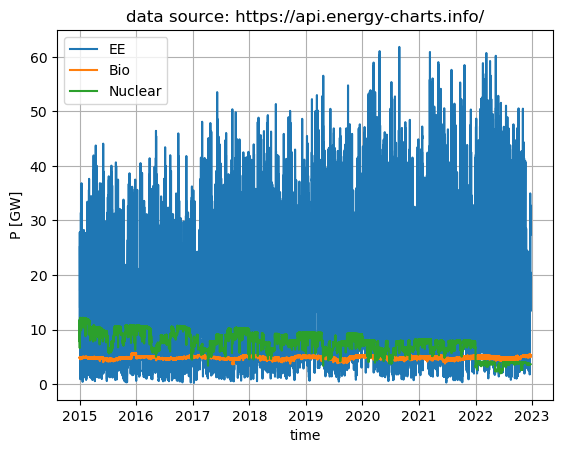

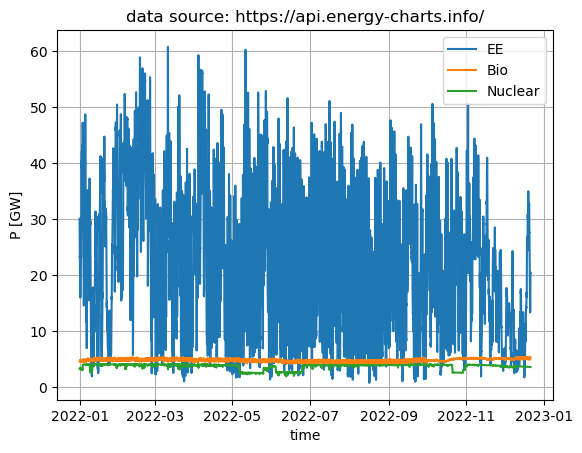

In [32]:
ee_bio_nuclear()